In [125]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D

import matplotlib
matplotlib.rc('figure', figsize=(10, 5))
plt.style.use('ggplot')


In [127]:
# Définition des constantes du milieu
G = 1. # module de cisaillement
nu = 0.25 # coefficient de Poisson

# Domaine d'étude
L = 10. 
H = 1.
N = 30 # discrétisation
X = np.linspace(0, L, N)
Y = np.linspace(0, L, N)
XX,YY = np.meshgrid(X,Y)

In [128]:
# Définition de la chambre
a = 0.01 # rayon 
xs,ys,zs = [L/2,L/2,H/2] # position 
dp = 1. # surpression

In [129]:
# Calcul de la déformation en surface

s = dp*(1-nu)*a**3/G 

iR = 1/((XX-xs)**2+(YY-ys)**2+zs**2)**(3/2)

ux = s*np.abs((XX-xs))*iR
uy = s*np.abs((YY-ys))*iR
uz = s*np.abs((-zs))*iR

/tmp/ipykernel_27292/3674350942.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, ax = axes[0], shrink=0.75)
/tmp/ipykernel_27292/3674350942.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, ax = axes[1], shrink=0.75)
/tmp/ipykernel_27292/3674350942.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, ax = axes[2], shrink=0.75)


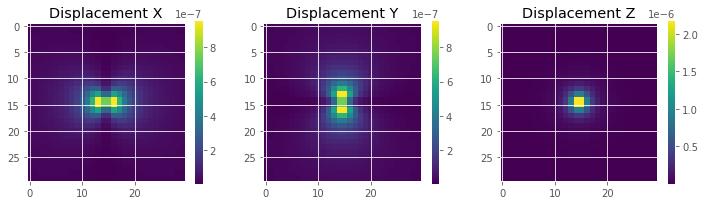

In [130]:
%matplotlib inline

fig,axes = plt.subplots(1, 3, figsize=(12,4))
im = axes[0].imshow(ux)
plt.colorbar(im, ax = axes[0], shrink=0.75)
axes[0].set_title("Displacement X")
im = axes[1].imshow(uy)
plt.colorbar(im, ax = axes[1], shrink=0.75)
axes[1].set_title("Displacement Y")
im = axes[2].imshow(uz)
plt.colorbar(im, ax = axes[2], shrink=0.75)
axes[2].set_title("Displacement Z")

plt.show()

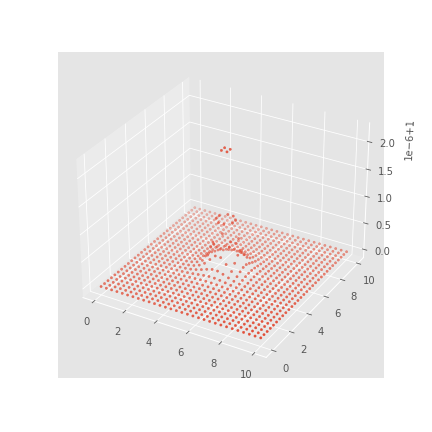

In [131]:
%matplotlib widget

# Réprésentation dans un maillage en 3D
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(projection='3d')
ax.scatter(XX+ux, YY+uy, H+uz, marker=".")

plt.show()

In [163]:
# Tirage aléatoire des chambres

# On tire des chambres sphériques contenues dans un cylindre de hauteur H de profondeur Z et de rayon R
H_magma_body = 1e3
Z_magma_body = 5e3
R_magma_body = 1e3

# Rayon des chambres
# # Hyp 1 : tq suivant une loi exponentielle d'esperance R
# R_mean_magma_chamber = 50. 
# Hyp 2 : tq suivant une loi normale d'esperance R et d'écart type SIGMA
R_mean_magma_chamber = 100. 
SIGMA_magma_chamber = 50.

# On tire des chambres jusqu'à que le volume de chambre soit X fois le volume du cylindre
X_fraction_volume = 0.01
volume_cible = X_fraction_volume*np.pi*R_magma_body**2*H_magma_body

class MagmaChamber : 
    def __init__(self,x,y,z,r):
        self.x = x 
        self.y = y 
        self.z = z 
        self.radius = r 
    def __str__(self):
        return f"{self.radius:.1f}km at ({self.x:.1f},{self.y:.1f},{self.z:.1f})"
    def distance(self, mc_b):
        return np.sqrt((self.x-mc_b.x)**2+(self.y-mc_b.y)**2+(self.z-mc_b.z)**2)

def check_for_collision(mc1,mc2,mc3):
    """Check if edge (mc1,mc2) is crossing mc3"""
    
    # Paramètres de la ligne mc1-mc2
    line_vector = np.array([mc2.x - mc1.x, mc2.y - mc1.y, mc2.z - mc1.z])
    line_point = np.array([mc1.x, mc1.y, mc1.z])

    # Paramètres de la sphère
    sphere_center = np.array([mc3.x, mc3.y, mc3.z])

    # Calcul du vecteur entre le centre de la sphère et le point sur la ligne le plus proche
    nearest_point = line_point + np.dot(line_vector, sphere_center - line_point) / np.dot(line_vector, line_vector) * line_vector
    distance = np.linalg.norm(nearest_point - sphere_center)

    # Vérification de l'intersection
    if distance <= mc3.radius:
        return True
    else:
        return False

        
magma_chambers = []
total_mc_vol = 0. 
while total_mc_vol < volume_cible :
    
    # tirage du centre de la chambre
    z = np.random.uniform(Z_magma_body, Z_magma_body+H_magma_body)
    r_pos = np.random.uniform(0., R_magma_body)
    theta = np.random.uniform(0, 2*np.pi)
    
    x = r_pos*np.cos(theta)
    y = r_pos*np.sin(theta)
    
    # tirage du rayon de la chambre
    # r = np.random.exponential(scale=R_mean_magma_chamber)
    r = np.random.normal(R_mean_magma_chamber, SIGMA_magma_chamber)
    
    # check that within the cylinder
    if r+r_pos > R_magma_body:
        continue 
    
    if ((z-Z_magma_body < r) or (Z_magma_body+H_magma_body-z < r)):
        continue
    
    # check that does not intersect with other chambers
    for chamber in magma_chambers:
        if np.sqrt((chamber.x-x)**2+(chamber.y-y)**2+(chamber.z-z)**2) < chamber.radius + r:
            continue
        
    # checks passed
    magma_chambers.append(MagmaChamber(x,y,z,r))
    total_mc_vol += 4/3*np.pi*r**3
    
print(len(magma_chambers))

9


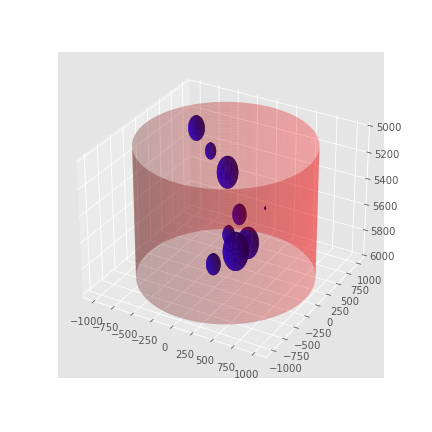

In [164]:
%matplotlib widget

def plot_sphere(ax, center, radius, text):
    phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)
    ax.plot_surface(x, y, z, color='b',  shade=True)
    # ax.text(x, y, z, text, color='red', fontsize=8, ha='center', va='center')
    
def plot_cylinder(ax, center, radius, height):
    phi = np.linspace(0, 2*np.pi, 100)
    z = np.linspace(0, height, 50)
    Z, Phi = np.meshgrid(z, phi)
    X = center[0] + radius * np.cos(Phi)
    Y = center[1] + radius * np.sin(Phi)
    ax.plot_surface(X, Y, Z + center[2], color='r', alpha=0.3)

    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

for i,mc in enumerate(magma_chambers):
    plot_sphere(ax, [mc.x, mc.y,mc.z], mc.radius, i+1)
    
plot_cylinder(ax, [0,0,Z_magma_body], R_magma_body, H_magma_body)
    
# ax.set_box_aspect([np.ptp(coord) for coord in zip(*[s[0] for s in spheres])])

ax.invert_zaxis()
plt.show()

In [165]:
# Création d'un graph

mc_graph = nx.Graph()

# 0. ajout de la chambre source
mc_graph.add_node(0, radius=-1, center_coord=np.array([-1,-1,-1]))
    
# 1. ajout des noeuds
for i,mc in enumerate(magma_chambers):
    mc_graph.add_node(i+1, radius=mc.radius, center_coord=np.array([mc.x,mc.y,mc.z]))

# 2. ajout des arrêtes
for i,mc1 in enumerate(magma_chambers):
    for j,mc2 in enumerate(magma_chambers):
        if i == j: continue 
        valid = True
        for k,mc3 in enumerate(magma_chambers):
            if (i==k) or (j==k): continue
            if check_for_collision(mc1,mc2,mc3): 
                valid = False
                break
        if valid : mc_graph.add_edge(i+1, j+1, distance=mc1.distance(mc2))

In [166]:
def draw_graph(G, node_size_comp, edge_width_comp, node_size_factor=400, edge_width_factor=4):   
    
    seed = 13648
    pos = nx.spring_layout(G, seed=seed)
    
    node_sizes = [G.nodes[node][node_size_comp]*node_size_factor for node in G.nodes]
    node_sizes[0] = 5*node_size_factor
    edge_sizes = [G.edges[edge][edge_width_comp]*edge_width_factor for edge in G.edges]
    
    fig,ax = plt.subplots(figsize=(8,8))

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
    nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        width=edge_sizes,
    )
    
    nx.draw_networkx_labels(G, pos, font_color="w")

    ax.set_axis_off()
    ax.set_title(f"Node size = {node_size_comp} ; egde width = {edge_width_comp}")
    fig.patch.set_facecolor('white')
    return fig,ax
    
# fig,ax = draw_graph(mc_graph, "radius", "distance", node_size_factor=50, edge_width_factor=1e-3)
# plt.show()

In [167]:
# Calcul des compressibilités (absolues : V*compressibilité) et des conductivitées

G = 10e9 # 10GPa : granite
R_conduct = 1. # rayon des conduits = 50m
mu_magma = 100 # 100 Pa.s : magma basaltique 1500K

for node in mc_graph.nodes:
    
    if mc_graph.nodes[node]["radius"] == -1 : continue # source
    
    mc_graph.nodes[node]["compressibility"] = 4/3*np.pi*mc_graph.nodes[node]["radius"]**3 * 3/(4*G) 
    
    for node2 in mc_graph.nodes:
        if mc_graph.nodes[node2]["radius"] == -1 : continue 
        try : 
            mc_graph[node][node2]["conductivity"] = np.pi*R_conduct**4/(8*mu_magma*mc_graph[node][node2]["distance"])
        except:
            pass # nodes not connected 

# Connexion de la chambre la plus profonde à la source
depths = np.array([center[2] for center in nx.get_node_attributes(mc_graph, "center_coord").values()])
radius = np.array(list(nx.get_node_attributes(mc_graph, "radius").values()))
depths_max = depths + radius
i_max_depth = depths_max.argmax()

distance_to_source = Z_magma_body+H_magma_body-depths_max.max()
mc_graph.add_edge(i_max_depth, 0, conductivity=np.pi*R_conduct**4/(8*mu_magma*distance_to_source))

In [168]:
# Répartition des distances
distances = list(nx.get_edge_attributes(mc_graph, "distance").values())
conductivity = np.array(list(nx.get_edge_attributes(mc_graph, "conductivity").values()))
compressibility = np.array(list(nx.get_node_attributes(mc_graph, "compressibility").values()))

print(f"Mean conductivity = {conductivity.mean():.2e}")
print(f"Mean compressibility = {compressibility.mean():.2e}")
print(f"Characteritic time = {compressibility.mean()/conductivity.mean():.2e}")

Mean conductivity = 8.48e-06
Mean compressibility = 2.84e-04
Characteritic time = 3.35e+01


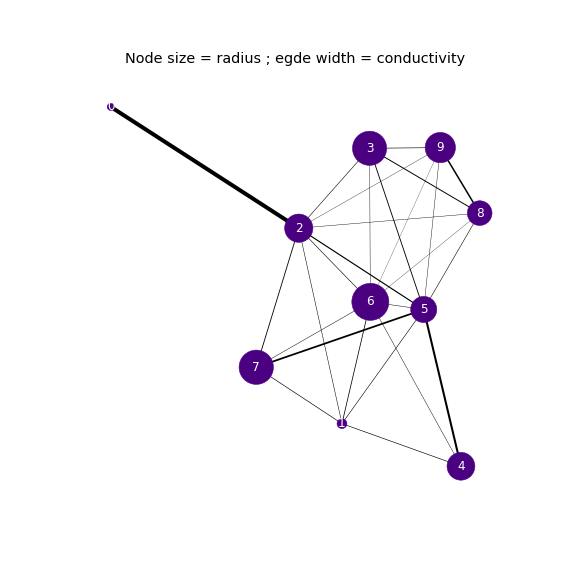

In [169]:
fig,ax = draw_graph(mc_graph, "radius", "conductivity", node_size_factor=10, edge_width_factor=1e5)
plt.show()

In [170]:
from pressure_timeseries import compute_pressure_time_serie

DELTA_P = 1e7 # 10 MPa
def source(t, t_s=0.): return DELTA_P if t >= t_s else 0

tmax = 5e2 # 1 an
p0 = np.zeros(len(mc_graph)-1)

p = compute_pressure_time_serie(mc_graph, source, tmax, p0)

[]

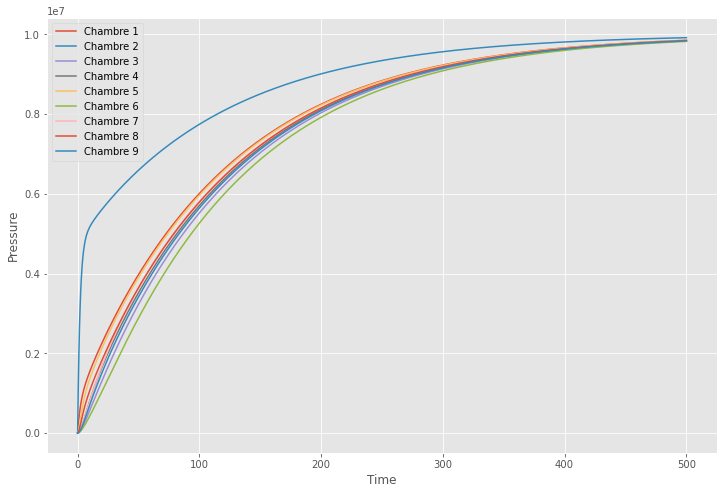

In [171]:
%matplotlib inline

# Tracé des pressions dans les chambres au cours du temps 
t_space = np.linspace(0, tmax, p.shape[0])
# plt.plot(t_space, [source(t_) for t_ in t_space], label="Source", color="k", ls=":")

fig,ax = plt.subplots(figsize=(12,8))

for i in range(len(mc_graph)-1):
    ax.plot(t_space, p[:,i], label=f"Chambre {i+1}")
    
ax.set_xlabel("Time")
ax.set_ylabel("Pressure")
plt.legend()
plt.plot()